In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run3NO_4hcopy_ratioFR_cov_mat_tim.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=30000
fit_stop=300000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

1.0054459521915013e-08


In [6]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-(2*time)/tau_cbo)*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [7]:
p_init=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        204100,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5,
        0.0007,
        57300,
        0.0139,
        2.7,
        0.0004,
        19000,
        0.01405,
        1.9,
        1.10668e-04,
        3.06805]

In [8]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [9]:
p_init=pars2

In [10]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [11]:
stdevs = np.sqrt(np.diag(cov_final))
for ipar in range(0,21):
    print(pars_final[ipar],"  +-  ",stdevs[ipar],"  \n")

0.22822202296693483   +-   1.2116718886583002e-05   

-33.75292891821194   +-   0.6784023361495102   

3.997475919665473   +-   0.00010292279342295706   

-0.0011078820163259858   +-   3.556492869414086e-05   

227163.0730457531   +-   20557.631054036374   

0.002331297101147664   +-   4.002239103781891e-07   

2.595771682838966   +-   0.0323659669766005   

-0.0004056280258097502   +-   0.00010720382067780284   

2.215431106412623   +-   0.26206138905081977   

0.0001742307657609414   +-   0.00010772666484597086   

-17.041093332566184   +-   0.6230555815996686   

-0.0006797495056251655   +-   9.534888005336506e-05   

63577.18217397141   +-   9168.8628478772   

0.013900751264040924   +-   2.260790241100589e-06   

2.7278575227268296   +-   0.13946975194341377   

0.0027910097792036757   +-   0.0005350438157292137   

21581.07015692472   +-   2147.975421435968   

0.014048874345226154   +-   4.572351992579049e-06   

1.9776652122099874   +-   0.1894208997214002   

2.670359473539271

In [12]:
pars_final

array([ 2.28222023e-01, -3.37529289e+01,  3.99747592e+00, -1.10788202e-03,
        2.27163073e+05,  2.33129710e-03,  2.59577168e+00, -4.05628026e-04,
        2.21543111e+00,  1.74230766e-04, -1.70410933e+01, -6.79749506e-04,
        6.35771822e+04,  1.39007513e-02,  2.72785752e+00,  2.79100978e-03,
        2.15810702e+04,  1.40488743e-02,  1.97766521e+00,  2.67035947e-05,
        3.63602218e+00])

In [13]:
stdevs

array([1.21167189e-05, 6.78402336e-01, 1.02922793e-04, 3.55649287e-05,
       2.05576311e+04, 4.00223910e-07, 3.23659670e-02, 1.07203821e-04,
       2.62061389e-01, 1.07726665e-04, 6.23055582e-01, 9.53488801e-05,
       9.16886285e+03, 2.26079024e-06, 1.39469752e-01, 5.35043816e-04,
       2.14797542e+03, 4.57235199e-06, 1.89420900e-01, 2.29434066e-05,
       8.59308464e-01])

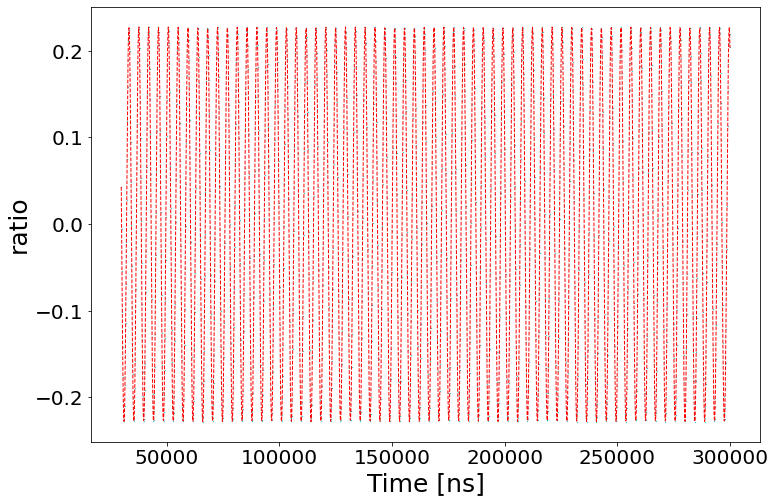

In [14]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [15]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

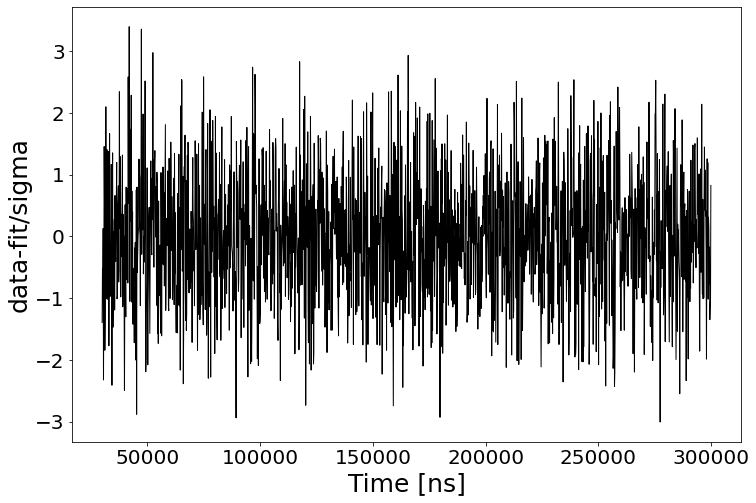

In [16]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run3no_res.jpg')

In [17]:
stdevs

array([1.21167189e-05, 6.78402336e-01, 1.02922793e-04, 3.55649287e-05,
       2.05576311e+04, 4.00223910e-07, 3.23659670e-02, 1.07203821e-04,
       2.62061389e-01, 1.07726665e-04, 6.23055582e-01, 9.53488801e-05,
       9.16886285e+03, 2.26079024e-06, 1.39469752e-01, 5.35043816e-04,
       2.14797542e+03, 4.57235199e-06, 1.89420900e-01, 2.29434066e-05,
       8.59308464e-01])

In [18]:
fou=abs(np.fft.fft(res))
xfft= np.linspace(0,6.667,num=1801)
xfft[800]

2.963111111111111

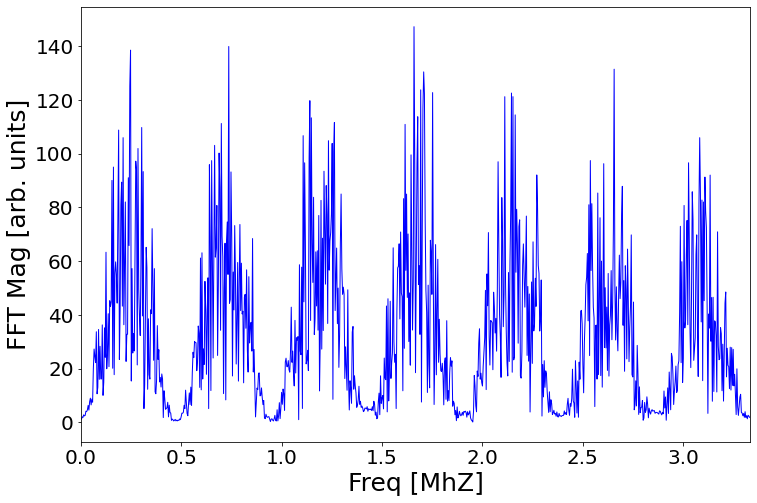

In [19]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run3no_fft.jpg')

In [20]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [21]:
ndf=fit_range-21
red_chi2=chi2/ndf
red_chi2

0.9906995114218689